In [35]:
import pandas as pd
import numpy as np
import itertools
import random
import math
from collections import defaultdict
from collections import Counter
import itertools
from matplotlib import pyplot as plt

# Reading data

In [19]:
alunos = pd.read_csv('alunos.csv', sep=';')
alunos.head()

,Data,Idade,Doenca
0,21/9/2019,16,sarampo
1,19/8/2006,18,meningite
2,15/1/2011,16,meningite
3,13/2/2009,17,catapora
4,19/6/2006,18,meningite


In [20]:
def pre_processing(path):
    students = pd.read_csv(path, sep=';')
    split_data = students.copy()
    complemento = students['Data'].str.split('/', expand=True)
    split_data['Dia'], split_data['Mes'], split_data['Ano'] = complemento[0], complemento[1], complemento[2]
    decades = [year[:-1]+'0' for year in split_data['Ano']]
    split_data['Decada'] = decades
    
    split_data['FaixaEtaria'] = [None]*len(split_data)
    bins = [int(split_data['Idade'].min())-1, int(split_data['Idade'].min())+2, int(split_data['Idade'].max())+1]
    labels = [str(bins[i-1])+'-'+str(bins[i]-1) for i in range(1, len(bins))]
    split_data['FaixaEtaria'] = pd.cut(split_data['Idade'], bins=bins, labels=labels)
    
    split_data['RangeMaximo'] = [str(split_data['Idade'].min())+'-'+str(split_data['Idade'].max())]*len(split_data)
    
    split_data = split_data[['Dia', 'Mes', 'Ano', 'Decada', 'Idade', 'FaixaEtaria', 'RangeMaximo', 'Doenca']]
    
    return students, split_data

### Separating data to generalize it when necessary

In [21]:
original_data, split_data = pre_processing('alunos.csv')

In [22]:
split_data

,Dia,Mes,Ano,Decada,Idade,FaixaEtaria,RangeMaximo,Doenca
0,21,9,2019,2010,16,15-17,16-20,sarampo
1,19,8,2006,2000,18,15-17,16-20,meningite
2,15,1,2011,2010,16,15-17,16-20,meningite
3,13,2,2009,2000,17,15-17,16-20,catapora
4,19,6,2006,2000,18,15-17,16-20,meningite
...,...,...,...,...,...,...,...,...
295,8,10,2017,2010,17,15-17,16-20,sarampo
296,21,9,2005,2000,19,18-20,16-20,catapora
297,29,5,2005,2000,16,15-17,16-20,sarampo
298,19,1,2007,2000,19,18-20,16-20,sarampo


In [12]:
students = split_data[['Dia','Mes','Ano','Idade','Doenca']]
students

,Dia,Mes,Ano,Idade,Doenca
0,21,9,2019,16,sarampo
1,19,8,2006,18,meningite
2,15,1,2011,16,meningite
3,13,2,2009,17,catapora
4,19,6,2006,18,meningite
...,...,...,...,...,...
295,8,10,2017,17,sarampo
296,21,9,2005,19,catapora
297,29,5,2005,16,sarampo
298,19,1,2007,19,sarampo


In [71]:
def initial_clusters(dataset, k):   
    def priority(dataset):
        generalization_order = [list(dataset.columns[i:-1]) for i in range(len(dataset.columns)-1)]
        generalization_order = [dataset.groupby(generalization_order[i]).groups for i in range(len(generalization_order))]

        return generalization_order
    
    clusters = defaultdict(list)
    clustered = set()
    generalization_order = priority(dataset)

    for i in range(len(generalization_order)):
        for key, value in zip(generalization_order[i].keys(), generalization_order[i].values()):
            if len(value) >= k and len(clustered.intersection(value)) == 0:
                # se o grupo do groupby é maior ou igual a k e nenhum dos valores já estiver agrupado
                clusters[key] = list(itertools.chain(value))
                clustered = clustered.union(clusters[key])
                
    return clusters, clustered

In [88]:
clusters, clustered = initial_clusters(students, 2)
clusters

defaultdict(list,
            {('5', '4', '2011', 18): [111, 212],
             ('1', '2011', 16): [2, 193],
             ('1', '2014', 20): [109, 275],
             ('1', '2015', 19): [178, 214],
             ('10', '2006', 19): [40, 209],
             ('10', '2012', 19): [175, 242, 299],
             ('11', '2007', 19): [15, 161],
             ('11', '2017', 16): [62, 119],
             ('11', '2019', 19): [21, 88],
             ('2', '2005', 18): [38, 55],
             ('2', '2006', 16): [29, 136],
             ('2', '2009', 17): [3, 248],
             ('2', '2012', 19): [60, 118],
             ('2', '2015', 20): [87, 102],
             ('3', '2007', 17): [154, 231],
             ('3', '2007', 19): [47, 155],
             ('3', '2013', 18): [148, 282],
             ('3', '2015', 17): [112, 254],
             ('3', '2017', 18): [100, 270],
             ('3', '2018', 16): [9, 96],
             ('4', '2005', 18): [67, 217],
             ('4', '2009', 20): [77, 210],
             ('4', 

In [91]:
periods_age = [['Idade'], ['FaixaEtaria'], ['RangeMaximo']]
periods_date = [['Dia', 'Mes', 'Ano'], ['Mes', 'Ano'], ['Ano'], ['Decada']]
all_combinations = list(itertools.product(periods_age, periods_date))
all_combinations = [list(itertools.chain.from_iterable(list_i)) for list_i in all_combinations]

all_combinations

[['Idade', 'Dia', 'Mes', 'Ano'],
 ['Idade', 'Mes', 'Ano'],
 ['Idade', 'Ano'],
 ['Idade', 'Decada'],
 ['FaixaEtaria', 'Dia', 'Mes', 'Ano'],
 ['FaixaEtaria', 'Mes', 'Ano'],
 ['FaixaEtaria', 'Ano'],
 ['FaixaEtaria', 'Decada'],
 ['RangeMaximo', 'Dia', 'Mes', 'Ano'],
 ['RangeMaximo', 'Mes', 'Ano'],
 ['RangeMaximo', 'Ano'],
 ['RangeMaximo', 'Decada']]

In [90]:
def sort_priority():
    return

def priority_level(dataset):
    periods_age = [['Idade'], ['FaixaEtaria'], ['RangeMaximo']]
    periods_date = [['Dia', 'Mes', 'Ano'], ['Mes', 'Ano'], ['Ano'], ['Decada']]
    all_combinations = list(itertools.product(periods_age, periods_date))
    all_combinations = [list(itertools.chain.from_iterable(list_i)) for list_i in all_combinations]
    all_combinations = [i for i in all_combinations if('FaixaEtaria' in i or 'RangeMaximo' in i or 'Decada' in i)]
    all_groups = [dataset.groupby(all_combinations[i]).groups for i in range(len(all_combinations))]

    return all_groups

def cluster_by_priority(dataset, clusters, clustered, k):
    not_clustered = list(set(dataset.index) - set(clustered))
    not_clustered_df = dataset.loc[not_clustered]
    groups = priority_level(not_clustered_df)

    for i in range(len(groups)):
        for key, value in zip(groups[i].keys(), groups[i].values()):
            if (len(value) - len(clustered.intersection(value)))>= k : # and len(clustered.intersection(value)) == 0:
                # se o grupo do groupby é maior ou igual a k e nenhum dos valores já estiver agrupado
                clusters[key] = list(itertools.chain(list(set(value) - set(clustered))))
                clustered = clustered.union(clusters[key])
                
    return clusters, len(dataset) - len(clustered), list(set(dataset.index) - set(clustered))

cluster_by_priority(split_data, clusters, clustered, 2)

(defaultdict(list,
             {('5', '4', '2011', 18): [111, 212],
              ('1', '2011', 16): [2, 193],
              ('1', '2014', 20): [109, 275],
              ('1', '2015', 19): [178, 214],
              ('10', '2006', 19): [40, 209],
              ('10', '2012', 19): [175, 242, 299],
              ('11', '2007', 19): [15, 161],
              ('11', '2017', 16): [62, 119],
              ('11', '2019', 19): [21, 88],
              ('2', '2005', 18): [38, 55],
              ('2', '2006', 16): [29, 136],
              ('2', '2009', 17): [3, 248],
              ('2', '2012', 19): [60, 118],
              ('2', '2015', 20): [87, 102],
              ('3', '2007', 17): [154, 231],
              ('3', '2007', 19): [47, 155],
              ('3', '2013', 18): [148, 282],
              ('3', '2015', 17): [112, 254],
              ('3', '2017', 18): [100, 270],
              ('3', '2018', 16): [9, 96],
              ('4', '2005', 18): [67, 217],
              ('4', '2009', 20): [77, 21

In [85]:
split_data.loc[[17, 146, 140, 127]]

,Dia,Mes,Ano,Decada,Idade,FaixaEtaria,RangeMaximo,Doenca
17,9,7,2010,2010,19,18-20,16-20,meningite
146,23,11,2007,2000,20,18-20,16-20,catapora
140,7,6,2007,2000,20,18-20,16-20,meningite
127,14,11,2010,2010,19,18-20,16-20,gripe


In [27]:
def clustering_remaining_tuples(dataset, clusters, clustered, k): # dataset split with age range
    def priority_level(dataset, age_level, date_level):
        if(age_level == 2 and date_level < 4):
            data = dataset[['Dia', 'Mes', 'Ano', 'FaixaEtaria', 'Doenca']]
            generalization_order = [list(dataset.columns[i:-1]) for i in range(len(data.columns[:-1]))]
            generalization_order = [dataset.groupby(generalization_order[i]).groups for i in range(len(generalization_order))]
        
            return generalization_order
    
    # Agrupar por década e intervalo de idade
    not_clustered = list(set(dataset.index) - set(clustered))
    not_clustered_df = dataset.loc[not_clustered]
    
    
    
    return not_clustered_df
    
clustering_remaining_tuples(split_data, clusters, clustered, 2)

,Dia,Mes,Ano,Decada,Idade,FaixaEtaria,RangeMaximo,Doenca
4,19,6,2006,2000,18,15-17,16-20,meningite
5,18,5,2010,2010,20,18-20,16-20,meningite
7,5,9,2013,2010,16,15-17,16-20,gripe
11,24,6,2009,2000,19,18-20,16-20,meningite
18,27,5,2005,2000,18,15-17,16-20,gripe
...,...,...,...,...,...,...,...,...
281,17,4,2008,2000,18,15-17,16-20,catapora
286,28,11,2014,2010,18,15-17,16-20,sarampo
289,1,6,2014,2010,16,15-17,16-20,catapora
293,6,11,2007,2000,18,15-17,16-20,meningite


In [30]:
list(range(5))

[0, 1, 2, 3, 4]

# k-anonimato

In [6]:
def k_anonymity(dataset, clusters):
    k_anonymized = pd.DataFrame([[None]*3]*len(dataset), columns=dataset.columns)
    for key, value in zip(clusters.keys(), clusters.values()):
        if not isinstance(key, list) and isinstance(key, str):
            if '-' not in key:
                k_anonymized.loc[value] = [[key, '{}-{}'.format(dataset['Idade'].min(), dataset['Idade'].max()), key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]
            else:
                k_anonymized.loc[value] = [['*', key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]

        if not isinstance(key, list) and isinstance(key, int):
            k_anonymized.loc[value] = [['*', key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]

        elif all(map(lambda x: isinstance(x, str), key)):
            k_anonymized.loc[value] = [[k for k in key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]

        else:
            to_fill = [key[0]]
            for i in range(1, len(key)):
                if type(key[i]) == str:
                    to_fill[0] = to_fill[0] + str('/'+key[i])
                else:
                    to_fill.append(key[i])
            k_anonymized.loc[value] = [to_fill+[dataset[dataset.columns[-1]].loc[v]] for v in value]

    return k_anonymized

In [7]:
def plot_histogram(clusters):
    lengths = []
    for cluster in clusters.values():
        lengths.append(len(cluster))

    counter = dict(sorted(Counter(lengths).items()))
    keys_str = [str(key) for key in counter.keys()]
    plt.bar(keys_str, counter.values())
    
    return plt.show()

# Chamadas de funções

In [12]:
clusters, clustered = initial_clusters(alunos_copy, 20)
all_clusters = clustering_remaining_tuples(alunos_copy, clusters, clustered, 20)

In [13]:
a = k_anonymity(alunos, all_clusters)
a.head()

,Data,Idade,Doenca
0,2010,15-19,sarampo
1,2000,15-19,meningite
2,2010,15-19,meningite
3,2000,15-19,catapora
4,2000,15-19,meningite


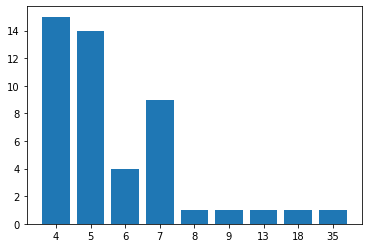

In [10]:
plot_histogram(all_clusters)